Used tutorial: https://muthu.co/segmenting-lines-in-handwritten-documents-using-a-path-planning-algorithm/

## Importing the scrolls


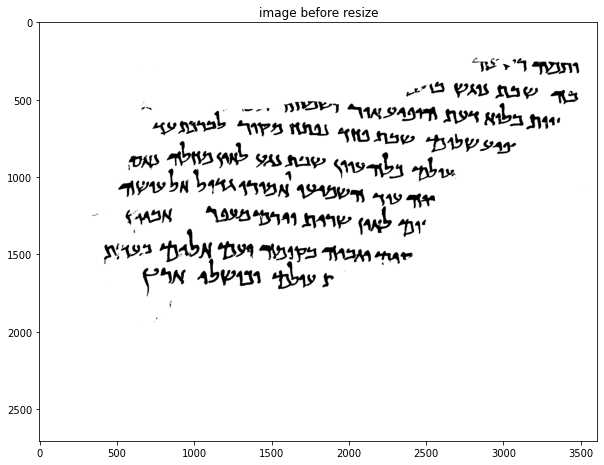

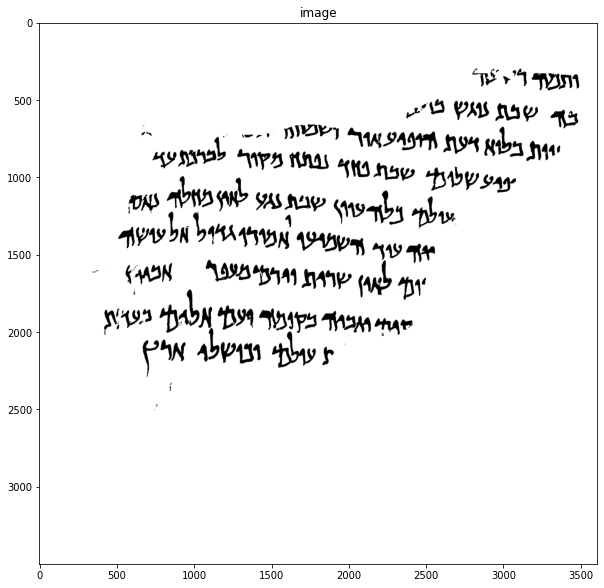

In [17]:
#Packages that need to be imported
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from PIL import Image
from skimage.filters import threshold_otsu


#For my mac usage
# easy_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P168-Fg016-R-C01-R01-binarized.jpg'
# hard_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P22-Fg008-R-C01-R01-binarized.jpg' 
# huge_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P344-Fg001-R-C01-R01-binarized.jpg'
# half_sentences_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P106-Fg002-R-C01-R01-binarized.jpg'
# divided_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P423-1-Fg002-R-C01-R01-binarized.jpg' 
# curly_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P123-Fg002-R-C01-R01-binarized.jpg' 
# vague_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P166-Fg007-R-C01-R01-binarized.jpg'

# wrong_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P168-Fg016-R-C01-R01-binarized.jpg'
# test_scroll = r'/Users/joostfranssen/Downloads/sample-test-2022 3/25-Fg001.pbm'
# test_scroll2 = r'/Users/joostfranssen/Downloads/sample-test-2022 3/124-Fg004.pbm'


# #For github usage
scroll = 'binary_scrolls/P513-Fg001-R-C01-R01-binarized.jpg'


#Read in the image
image = cv2.imread(scroll, cv2.IMREAD_UNCHANGED)

#Calculate the reshaping height
rescaled_height = image.shape[0]/3500

plt.figure(figsize=(10,10))
plt.axis()
plt.title("image before resize")
plt.imshow(image, cmap="gray")
plt.show()

#Reshape the height of each image to a specific value such that the line segmentation works good for every image
image = cv2.resize(image, (image.shape[1], 3500))


plt.figure(figsize=(10,10))
plt.axis()
plt.title("image")
plt.imshow(image, cmap="gray")
plt.show()


In [18]:
#Function to threshold the image
def thresholding(image):
    _ ,thresh = cv2.threshold(image,80,255,cv2.THRESH_BINARY_INV)
    return thresh

#Function to dilated an image
def dilated_image(image):
    thresh_img = thresholding(image)
    kernel = np.ones((4,35), np.uint8)
    dilated = cv2.dilate(thresh_img, kernel, iterations = 1) 
    return dilated

#Function to ivert a image
def invert_image(image):
    invert = cv2.bitwise_not(image) 
    return invert


In [19]:
#Calculate the horizontal projections
def horizontal_projections(image):
    return np.sum(image, axis=1) 

#Peak finder for the horizontal projections
def find_peaks_image(image):
    dilated = dilated_image(image)
    hpp = horizontal_projections(dilated)
    
    #The minimum peak assures that we have a lower bound
    minimum_peak = int((np.max(hpp)-np.min(hpp))/12)
    
    #The distance assures that we have a certain distance between peaks
    peaks, _ = find_peaks(hpp, height=minimum_peak, distance=120)
    return hpp, peaks


#Use the calculated peaks to create small areas of where there must be sentences. 
def find_not_peak_regions(hpp, peaks):
    not_peaks = []
    not_peaks_index = []
    count = 0
    x = 0
    line_size = 10
    for i, hppv in enumerate(hpp):
        if x > (len(peaks) - 1):
            not_peaks.append([i, hppv])
        elif i < (peaks[x] - line_size) or i > (peaks[x] + line_size):
            not_peaks.append([i, hppv])
        else:
            count += 1
            if count == ((line_size*2) - 1):
                x += 1
                count = 0
    return not_peaks



#The hpp clusters are created such that we have areas in which the path finder can search, creating walking regions in the image
def get_hpp_walking_regions(peaks_index):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []

        #get the last cluster
        if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
            
    return hpp_clusters

#Create new line images such that we can copy the segmented line unto clean images
def white_array(height, width):
    image = np.zeros([height,width],dtype=np.uint8)
    image.fill(255)
    return image


#Get the binary values of a image
def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary*1
    return binary

In [20]:
#Copied from the github mentioned above, adjusted for our problem. Created a range of goals.

#A star path planning algorithm 
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    lower_limit = goal[0]
    upper_limit = goal[0] + lower_limit 
    
    count = 0
    while oheap:
        count += 1
        
        current = heappop(oheap)[1]
        
        #If there is not a path break after 30 times the length of the input iterations, no clear path will probably be found
        if count > goal[1]*30:
            break
            
        #The goal of the path finder can be somewhere in the range of the walking region at the end
        if current[1] == goal[1] and (current[0] > lower_limit and current[0] < upper_limit):
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))      
    return []

In [21]:
#Segment all the lines using the A* algorithm, and find a path. 
def create_A_star_lines(img, hpp_clusters):
    binary_image = get_binary(img)

    line_segments = []
    for i, cluster_of_interest in enumerate(hpp_clusters):
        nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]

        #The goal of the path finder is between the middle and the lower bound of the walking region (this seemed most effective)
        path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2), nmap.shape[1]-1)))

        #Finding a path is impossible, then just draw a straight line from begin to end
        if path.shape[0] == 0:
            line_new = []
            size_cluster = int(nmap.shape[0]/2)
            for i in range(nmap.shape[1] - 1):
                line_new.append([size_cluster, nmap.shape[1]-i -1])
                line = []
            line_new = np.asarray(line_new)
            offset_from_top = cluster_of_interest[0]
            line_new[:,0] += offset_from_top
            line_segments.append(line_new)
        #If we have found a path we store it
        else:
            offset_from_top = cluster_of_interest[0]
            path[:,0] += offset_from_top
            line_segments.append(path)
    return line_segments

#Create the seperate line images.
def create_line_image(line_segments):
    line_count = len(line_segments)
    line_image = []

    #Find the upper and lower bound, for the size of the line image
    for line_index in range(line_count-1):
        upper_bound = np.min(line_segments[line_index][:, 0])
        lower_bound = np.max(line_segments[line_index+1][:, 0])
        height = lower_bound - upper_bound
        width = image.shape[1]
        white_line_image = white_array(height, width)
        offset_top = upper_bound


        #Creates white areas around the sentences, such that bits and pieces of other sentences do not get in the line image
        for i in range(white_line_image.shape[0]):
            for j in range(white_line_image.shape[1] -1):
                if (line_segments[line_index][white_line_image.shape[1] - 2 - j][0] - i > upper_bound) or (i + offset_top > line_segments[line_index+1][white_line_image.shape[1] - 2 - j][0]) :              
                    white_line_image[i][j] = 255     
                else:
                    white_line_image[i][j] = image[upper_bound + i][j]

        line_image.append(white_line_image)
    return line_image


In [22]:
#Rescale the height of the lines back to the normal size
def rescale_lines(line_image, rescale_height):
    new_line_image = []
    for i in range(len(line_image)):
        height = line_image[i].shape[0]
        new_height = int(rescale_height * height)
        new_line = cv2.resize(line_image[i], (line_image[i].shape[1], new_height))
        new_line_image.append(new_line)
    return new_line_image
        
        

In [23]:
#Function for the complete line segmentation steps
def line_segmentation(image, rescaled_height):
    #Find the horizontal projections and the peaks of the projections
    hpp, peaks = find_peaks_image(image)

    #find all the indexes that do not contain the peak
    not_peaks = find_not_peak_regions(hpp,peaks)
    not_peaks_index = np.array(not_peaks)[:,0].astype(int)

    #Create walking regions for the A* star algorithm path finder
    hpp_clusters = get_hpp_walking_regions(not_peaks_index)

    #dilate the image such that we find a path around the dilation
    dilated = dilated_image(image)

    #invert it back for the path finder because that is build to avoid black pixels
    img = invert_image(dilated)

    #Find the paths for the segmentation
    line_segments = create_A_star_lines(img, hpp_clusters)

    #Create the segmented line images
    line_image = create_line_image(line_segments)
    
    rescaled_lines = rescale_lines(line_image, rescaled_height)
    
    return rescaled_lines

# Word segmentation

##### Preprocess the lines for word segmentation 

In [24]:
#Remove the top white part of a image
def remove_top_image(image):
    thresh_image = thresholding(image)
    hpp_image = horizontal_projections(thresh_image)
    for i in range(len(hpp_image)):
        if hpp_image[i] != 0:
            image_new = image[i:, :]
            break 
    return image_new

#Remove the bottom white part of a image
def remove_bottom_image(image):
    thresh_image = thresholding(image)
    hpp_image = horizontal_projections(thresh_image)
    for i in range(len(hpp_image)-1, 0, -1):
        if hpp_image[i] != 0:
            image_new = image[:i, :]
            break 
    return image_new  

#Find the vertical image projections
def vertical_projections(image):
    return np.sum(image, axis=0) 

#Remove noise from a image using the meadian blur
def remove_noise(image):
    return cv2.medianBlur(image, 5)

#preprocesses the lines
def pre_process_lines(lines):
    pre_processed_lines = []
    kernel = np.ones((10,10), np.uint8)
    
    for i in range(len(lines)):
        line = lines[i]
        
        #threshold line
        thresh_line = thresholding(line)
        
        #remove noise
        noise_free_line = remove_noise(thresh_line)
        
        #dilate the remaining part
        dilated_line = cv2.dilate(noise_free_line, kernel, iterations = 1)
        
        #append the line
        pre_processed_lines.append(dilated_line)
    return pre_processed_lines

#Remove the white areas that are found in the first and last line
def remove_white_areas_first_last_line(line_image):
    first_line = line_image[0]
    last_line = line_image[len(line_image)-1]

    line_image[0] = remove_top_image(first_line)
    line_image[len(line_image)-1] = remove_bottom_image(last_line)
    return line_image

In [25]:
#Find the length of periods with white pixels and create seperate words if there are enough white pixels
def find_words_for_zero_period(image, threshold):
    words = []
    vpp_image = vertical_projections(image)
    
    #find indexes where the vpp is not zero, so there are black pixels
    result_zeros = np.where(vpp_image!=0)
    lowest = result_zeros[0][0]
    for i in range(len(result_zeros[0])-1):
        diff = result_zeros[0][i+1] - result_zeros[0][i] 
        #skip white periods that are not long enough
        if diff > 1 and diff < threshold:
            continue
        elif diff > 1:
            highest = result_zeros[0][i]
            new_word = [lowest, highest]
            words.append(new_word)
            lowest = result_zeros[0][i+1]
              
    if lowest + 35 < result_zeros[0][len(result_zeros[0])-1]:
        highest = result_zeros[0][len(result_zeros[0])-1]
        new_word = [lowest, highest]
        words.append(new_word)
        lowest = result_zeros[0][i+1]       
    
    return words 

#Create the image for one specific word in which we remove the top and bottom white spaces
def get_word_image(image, index_words):
    words = []
    for i in range(len(index_words)):
        #Get word
        word_new = image[:,index_words[i][0]:index_words[i][1]]
        if word_new.shape[1] < 15:
            continue 
        words.append(word_new)
    return words


#Create the word image for all lines
def create_words(line_image, pre_processed_lines):
    words_per_line = []
    for line in range(len(line_image)):
        index_words = find_words_for_zero_period(pre_processed_lines[line], 10)
        words = get_word_image(line_image[line], index_words) 
        words_per_line.append(words)
    return words_per_line

In [26]:
#Create all the lines and words per line in this part
def get_words_per_line(image, rescaled_height):
    #Get the line images for the word segmentation
    line_image = line_segmentation(image, rescaled_height)
    
    line_image = remove_white_areas_first_last_line(line_image)

    #Pre process all the lines such that we can use them for the word and character segmentation
    pre_processed_lines = pre_process_lines(line_image)

    #Get the words that can be segmented on each line
    words_per_line = create_words(line_image, pre_processed_lines)
    return words_per_line


## Character Recognition copied from our github

In [27]:
from keras.models import load_model

In [28]:
#Load in the pre trained model
model = load_model('models/trained_LeNet_model.h5') 

## Character segmentation

In [29]:
#Find the boundingboxes of the letters
def boundingboxes_letters(image, image_dilated):
    boxcoordinates = []
    words_image = []
    letters = []

    copy = image.copy()
    thresholded = thresholding(image_dilated)

    cnts = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    for c in cnts:
        topleftx, toplefty, width, height = cv2.boundingRect(c)
        next_letter = [topleftx, toplefty, width, height]
        letters.append(next_letter)

    #Sort the letters based on the x values
    letters = sorted(letters, reverse=False)


    for letter in letters:
        topleftx, toplefty, width, height = letter

        #Reject contours that are too big or small to be likely letters, from average data taken
        #Normal minima are height = 27, width = 17
        if height<40 or width<30:
            continue

        #Normal maxima are height = 140, width = 80
        if height>300 or width>500:
            continue

        cv2.rectangle(copy, (topleftx, toplefty), (topleftx + width, toplefty + height), (0,0,255), 2)  
        boxcoordinates.append((topleftx, toplefty, width, height))

        character = image[toplefty:toplefty+height, topleftx:topleftx+width]
        words_image.append(character)
    
    return words_image, copy, boxcoordinates

In [41]:
#Find the middle part of a letter, using a peak finder on where the most vertical projections are
def find_middle_part_letter(image):
    hpp_image = thresholding(image)
    hpp_image = horizontal_projections(hpp_image)
    minimum_peak = int((np.max(hpp_image)-np.min(hpp_image))/3)
    peaks, _ = find_peaks(hpp_image, height=minimum_peak , distance=100) 
    if len(peaks) != 0:
        toplefty = max(peaks[0]-20, 0)
        height = min(40, image.shape[0]-toplefty)
        new_image = image[toplefty:toplefty+height, :]
    else:
        new_image = image
    return new_image


#Calculate the horizontal projections and find the peaks of white areas
def not_bb_divider_peaks(image):
    vpp = vertical_projections(image)
    minimum_peak = int((np.max(vpp)-np.min(vpp))/3)
    peaks, _ = find_peaks(vpp, height=minimum_peak , distance=60)
    new_peaks = []
    for peak in peaks:
        #peaks lower than x value of 30 or 30 from end are not really dividers 
        if peak < 27:
            continue
        elif peak > (image.shape[1] - 27):
            continue
        else:
            new_peaks.append(peak)
        
    return new_peaks
    
#Divided the characters that are too large based on the peaks found in not_bb_divider_peaks()
def divided_chars(image, peaks):
    chars = []
    if len(peaks) == 0:
        first_char = image[:,:]
    else:
        first_char = image[:,0:peaks[0]]
    chars.append(first_char)
    for i in range(len(peaks)):
        if i+1 == len(peaks):
            char = image[:,peaks[i]:image.shape[1]]
        else:
            char = image[:,peaks[i]:peaks[i+1]]
        chars.append(char)
    return chars


#Handcrafted function to divided characters that have too large boundingboxes to be one letter
def not_bb_divided(image):
    character = []
    middle_part = find_middle_part_letter(image)
    peaks_divider = not_bb_divider_peaks(middle_part)
    characters = divided_chars(image, peaks_divider)
    for i in range(len(characters)):
        if characters[i].shape[0] == 0 or characters[i].shape[1] == 0:
            continue 
        else:
            character.append(characters[i])
    return character

   
    
#If parts of the word are not obtained as bounding box we add them manually
def adjust_bb_for_mistakes(word_bb_image, coordinates, word, char):
    count = 1
    if len(coordinates) != 0:
        for i in range(len(coordinates)-1):
            toprightx = coordinates[i][0]+coordinates[i][2]
            distance_between_bb = coordinates[i+1][0] - toprightx
            
            #If the boundingboxes do not connect, we create a new boundingbox in the middle
            if distance_between_bb > 25:
                character = word[:, toprightx:coordinates[i+1][0]]
                char.insert(i+count, character)
                count+=1
            
        #Check if at the end of the bb range there is still something left
        toprightx = coordinates[len(coordinates)-1][0] + coordinates[len(coordinates)-1][2]
        if (toprightx) < word_bb_image.shape[1] - 15:
            char.pop()
            character = word[:,coordinates[len(coordinates)-1][0]:]
            char.append(character)

        #Check if the first boundingbox starts at the beginning of the word
        if coordinates[0][0] > 0 and len(coordinates) > 1:
            new_width = coordinates[0][0] + coordinates[0][2]
            char.pop(0)
            character = word[:,0:new_width]
            char.insert(0, character)      
    return char

In [42]:
#Function to erode images such that we hope to find more boundingboxes in the too large images to be one character
def erosion_char_finder(double_char):
    characters = []
    erosion_level = 2
    kernel = np.ones((erosion_level,erosion_level), np.uint8)
    double_char_dilate = cv2.dilate(double_char, kernel, iterations=1)
    chars, test_image, coordinates = boundingboxes_letters(double_char, double_char_dilate)
    
    while len(chars) == 1:
        kernel = np.ones((erosion_level,erosion_level), np.uint8)
        double_char_dilate = cv2.dilate(double_char, kernel, iterations=1)
        chars, test_image, coordinates = boundingboxes_letters(double_char, double_char_dilate)
        erosion_level += 1
        
    for x in range(len(chars)):
        #Too avoid that if we have a bb above another bb that it creates a new unwanted character
        if (x + 1) < len(chars) and coordinates[x+1][0] > coordinates[x][0] and coordinates[x+1][2] < (coordinates[x][2] - coordinates[x+1][0]):
            characters.append(double_char)
            break
        else:
            topleftx = max((coordinates[x][0] - 2), 0)

            #Often if we have two conjoint letters we have a too small bounding box for the last letter
            #Therefore we take the full bb of everything from the last letter onwards. 
            if x == (len(chars) -1):
                width = double_char.shape[1]-coordinates[x][0]
            else:
                width = min((coordinates[x][2] + 2), (double_char.shape[1]-coordinates[x][0]))
            new_char = double_char[:, topleftx:topleftx+width]
            characters.append(new_char)
    return characters


def find_characters_in_word(word):
    #character finder in total:
    word_copy = word.copy()

    #the first time we have a word we dilate such that we can find letters that are already seperated form others
    kernel = np.ones((3,3), np.uint8)
    word_copy_dilate = cv2.erode(word_copy, kernel, iterations=1)

    char, word_bb_image, coordinates = boundingboxes_letters(word_copy, word_copy_dilate)     
    
    #Adjust the charachters bb in a word for missing parts
    char = adjust_bb_for_mistakes(word_bb_image, coordinates, word, char)
    
    characters = []

    #If we do not find boundingboxes within the word, the word itself is a letter, or it does not contain clear bbs
    if len(char) == 0:
        if word_copy.shape[1] > 100:
            characters_handcrafted_div = not_bb_divided(word_copy)
            for l in range(len(characters_handcrafted_div)):
                characters.append(characters_handcrafted_div[l])
        else:
            characters.append(word)
    else:
        for i in range(len(char)):
            if char[i].shape[1] > 85:
                new_char_bb = erosion_char_finder(char[i])
                
                
                if len(new_char_bb) == 0:
                    #Still searching for the best parameter for this
                    if char[i].shape[1] > 90:
                        #this is a handcrafted divider
                        characters_handcrafted_div = not_bb_divided(char[i])
                        for u in range(len(characters_handcrafted_div)):
                            characters.append(characters_handcrafted_div[u])
                    else:
                        characters.append(char[i])
                else:
                    for x in range(len(new_char_bb)):
                        if new_char_bb[x].shape[1] > 90:
                            new_new_char_bb = erosion_char_finder(new_char_bb[x])
                            if len(new_new_char_bb) == 0:
                                if new_char_bb[x].shape[1] > 86:
                                    characters_handcrafted_div = not_bb_divided(new_char_bb[x])
                                    for u in range(len(characters_handcrafted_div)):
                                        characters.append(characters_handcrafted_div[u])
                                else:
                                    characters.append(new_char_bb[x])
                            else:
                                if len(new_new_char_bb) == 1:
                                    if new_new_char_bb[0].shape[1] > 85:
                                        characters_handcrafted_div = not_bb_divided(new_char_bb[0])
                                        for u in range(len(characters_handcrafted_div)):
                                            characters.append(characters_handcrafted_div[u])
                                else:
                                    for y in range(len(new_new_char_bb)):
                                        characters.append(new_new_char_bb[y])
                        else:
                            characters.append(new_char_bb[x])
            else:
                characters.append(char[i])
    return characters

## Final characters for all words still need to implement the loops here and stuff

In [32]:
#To find the all the characters in a line
def characters_per_line(words):
    char_per_word = []
    for i in range(len(words)):
        characters = find_characters_in_word(words[i])
        white_parts_char_removed = []
        
        #Remove unnecessary white parts at the top and bottom of characters
        for j in range(len(characters)):
            char_bot = remove_bottom_image(characters[j])
            char_top = remove_top_image(char_bot)
            white_parts_char_removed.append(char_top)
        if len(characters) != 0:
            char_per_word.append(white_parts_char_removed)
        else:
            char_per_word.append(characters)
    return char_per_word   

## Now we can resize and input the seperate charachters into the model and make predictions, and create a text file to print to

In [35]:
#Find the hebrew character corresponding to our number output
def find_hewbrew_character(number):
    if number == 0: #Alef
        char = "א"
    if number == 1: #Ayin
        char = "ע"
    if number == 2: #Bet
        char = "ב"
    if number == 3: #Dalet
        char = "ד"
    if number == 4: #Gimel
        char = "ג"
    if number == 5: #He
        char = "ה"
    if number == 6: #Het
        char = "ח"
    if number == 7: #Kaf
        char = "כ"
    if number == 8: #Kaf-final
        char = "ך" 
    if number == 9: #Lamed
        char = "ל"
    if number == 10: #Mem
        char = "ם"
    if number == 11: #Mem-medial
        char = "מ"
    if number == 12: #Nun-final
        char = "ן"
    if number == 13: #Nun-medial
        char = "נ"
    if number == 14: #Pe
        char = "פ"
    if number == 15: #Pe-final
        char = "ף"
    if number == 16: #Qof
        char = "ק"
    if number == 17: #Resh
        char = "ר"
    if number == 18: #Samekh
        char = "ס"
    if number == 19: #Shin
        char = "ש"
    if number == 20: #Taw
        char = "ת"
    if number == 21: #Tet
        char = "ט"
    if number == 22: #Tsadi-final
        char = "ץ"
    if number == 23: #Tsadi-medial
        char = "צ"
    if number == 24: #waw
        char = "ו"
    if number == 25: #Yod
        char = "י"
    if number == 26: #Zayin
        char = "ז"
    return char

#Get the predictions per character in a word
def make_predictions(word):
    char_resized_final = []
    for i in range(len(word)):
        char_resized = cv2.resize(word[i], (38, 48))
        char_resized_final.append(char_resized)
    char_array = np.array(char_resized_final) 
    char_array = char_array.reshape(char_array.shape[0], 48, 38, 1)
    predictions = model.predict(char_array)
    classes = np.argmax(predictions, axis = 1)
    return classes


#Get the words per line
words_per_line = get_words_per_line(image, rescaled_height)





In [43]:
#Create a text file in which the answers are printed
f = open('hoi' + ".txt","w+", encoding='utf-8')
for i in range(len(words_per_line)):
    line_characters = characters_per_line(words_per_line[i])
    for j in range(len(line_characters)-1,-1,-1):
        prediction_word = make_predictions(line_characters[j])
        for x in range(len(prediction_word)-1, -1, -1):
            f.write(find_hewbrew_character(prediction_word[x]))
        f.write(" ")
    f.write("\n")
f.close()